# CS 5683 - Big Data Analytics
## Project - 3: $k$-means clustering*
### Suraj Pawar, Pankajdeer Bikumalla

In [23]:
!pip install pyspark

In [24]:
# import libraries
import os
import shutil
import sys
from operator import add
import itertools
import numpy as np
import random
import time as time
from pyspark import SparkContext
import matplotlib.pyplot as plt 
import seaborn as sns
import matplotlib.ticker as ticker

font = {'size'   : 18}    
plt.rc('font', **font)

import matplotlib as mpl

In [ ]:
# initialize the spark context
sc = SparkContext(appName="Spark Apriori")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Reading the data

In [26]:
path = "/content/drive/My Drive/Coursework/CS 5683_Big_Data/Project-3/data.txt"
# path = "/content/drive/My Drive/3Sem/CS5683/Projects/Project 3/data.txt"

data = np.genfromtxt(path)
n_examples, n_features = data.shape

kc = 10 # number of clusters
max_iterations = 20 # maximum number of iterations

In [27]:
# import the data
data_rdd = sc.textFile(path,2)
# data_rdd = sc.parallelize(data,2)

# count the total number of baskets
print('Total number of examples = ', data_rdd.count())

datafloat = data_rdd.map(lambda line: ([float(item) for item in line.strip().split(' ')]))
datazipped = datafloat.zipWithIndex().map(lambda x: (x[1],x[0]))

for val in datazipped.take(2):
  print(val)

Total number of examples =  4601
(0, [0.0, 0.64, 0.64, 0.0, 0.32, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.64, 0.0, 0.0, 0.0, 0.32, 0.0, 1.29, 1.93, 0.0, 0.96, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.778, 0.0, 0.0, 3.756, 61.0, 278.0, 1.0])
(1, [0.21, 0.28, 0.5, 0.0, 0.14, 0.28, 0.21, 0.07, 0.0, 0.94, 0.21, 0.79, 0.65, 0.21, 0.14, 0.14, 0.07, 0.28, 3.47, 0.0, 1.59, 0.0, 0.43, 0.43, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.132, 0.0, 0.372, 0.18, 0.048, 5.114, 101.0, 1028.0, 1.0])


In [44]:
def initialize_centroid(data, num_clusters):
  sample = sc.parallelize(data.takeSample(False, num_clusters))
  centroids = sample.map(lambda x : x[1])
  centroids = centroids.zipWithIndex().map(lambda x: (x[1],x[0]))
  return centroids
#
centroids = initialize_centroid(datazipped, kc)

for item in centroids.take(2):
  print(item)

(0, [0.07, 0.0, 0.15, 0.0, 1.53, 0.15, 0.0, 0.46, 0.0, 0.0, 0.07, 0.46, 0.46, 0.0, 0.0, 0.0, 0.07, 0.0, 0.76, 0.0, 0.38, 0.0, 0.0, 0.0, 0.69, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.15, 0.0, 0.0, 0.0, 0.0, 0.07, 0.0, 0.0, 0.61, 0.0, 0.0, 0.0, 0.0, 0.022, 0.0, 0.0, 0.033, 0.0, 1.705, 36.0, 220.0, 0.0])
(1, [0.0, 0.0, 0.0, 0.0, 0.32, 0.32, 0.0, 0.0, 0.0, 0.0, 0.0, 0.32, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.3, 0.0, 0.98, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.32, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.65, 0.0, 0.0, 0.0, 0.0, 0.0, 0.257, 0.0, 0.0, 0.0, 0.0, 1.3, 7.0, 104.0, 0.0])


In [45]:
# printing the k-centroids
print("Initial k-centroids of K-means: ")
for item in centroids.collect():
  print(item)

Initial k-centroids of K-means: 
(0, [0.07, 0.0, 0.15, 0.0, 1.53, 0.15, 0.0, 0.46, 0.0, 0.0, 0.07, 0.46, 0.46, 0.0, 0.0, 0.0, 0.07, 0.0, 0.76, 0.0, 0.38, 0.0, 0.0, 0.0, 0.69, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.15, 0.0, 0.0, 0.0, 0.0, 0.07, 0.0, 0.0, 0.61, 0.0, 0.0, 0.0, 0.0, 0.022, 0.0, 0.0, 0.033, 0.0, 1.705, 36.0, 220.0, 0.0])
(1, [0.0, 0.0, 0.0, 0.0, 0.32, 0.32, 0.0, 0.0, 0.0, 0.0, 0.0, 0.32, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.3, 0.0, 0.98, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.32, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.65, 0.0, 0.0, 0.0, 0.0, 0.0, 0.257, 0.0, 0.0, 0.0, 0.0, 1.3, 7.0, 104.0, 0.0])
(2, [0.0, 0.0, 0.74, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.74, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.99, 1.87, 0.0, 1.87, 0.0, 0.74, 0.74, 0.0, 0.0, 0.0, 1.49, 0.74, 0.37, 0.0, 0.0, 0.0, 0.0, 0.0, 0.37, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.131, 0.043, 0.043, 0.0, 0.0, 2.468, 15.0, 195.0, 0.0])
(3, [0.0, 0.0, 0.0, 0.0

In [46]:
def calculate_distance_euclidien(centroid, data_element):
    centroid_features = np.array(centroid[1])
    data_element_features = np.array(data_element[1])
    distance = np.linalg.norm(centroid_features - data_element_features)
    return (data_element[0], (centroid[0], distance))

def calculate_distance_manhattan(centroid, data_element):
    centroid_features = np.array(centroid[1])
    data_element_features = np.array(data_element[1])
    distance = np.sqrt(np.sum(np.abs(centroid_features - data_element_features)))
    return (data_element[0], (centroid[0], distance))

def min_distance(row):
    element_index = row[0]
    centroids_distances_list = row[1]
    minimum_distance = -1
    closest_centroid = None
    min_centroid_index = -1
    for item in centroids_distances_list:
        centroid_index = item[0]
        distance = item[1]
        if (minimum_distance == -1) or (distance < minimum_distance):
            minimum_distance = distance
            min_centroid_index = centroid_index
            closest_centroid = (min_centroid_index, minimum_distance)
    return (element_index, closest_centroid)

def assign_cluster_euclidean(centroids, data):
  centroids_data = centroids.cartesian(data)
  data_centroids_distances = centroids_data.map(lambda x: calculate_distance_euclidien(x[0], x[1]))
  data_assignedto_closest_cluster = data_centroids_distances.groupByKey().map(lambda x: (x[0], list(x[1]))).map(lambda x: min_distance(x))

  return data_assignedto_closest_cluster

def assign_cluster_manhattan(centroids, data):
  centroids_data = centroids.cartesian(data)
  data_centroids_distances = centroids_data.map(lambda x: calculate_distance_manhattan(x[0], x[1]))
  data_assignedto_closest_cluster = data_centroids_distances.groupByKey().map(lambda x: (x[0], list(x[1]))).map(lambda x: min_distance(x))

  return data_assignedto_closest_cluster


In [47]:
def compute_new_centroid(centroid_index, cluster_elements):
    all_cluster_elements = []
    for element in cluster_elements:
        # element = ([5.4, 3.7, 1.5, 0.2, u'Iris-setosa'], 0.6999999999999994)
        all_cluster_elements.append(element[0])
    #centroid coordinates: computation
    averageArray = list(np.average(all_cluster_elements, axis = 0))
    new_centroid = (centroid_index, averageArray)
    return new_centroid

def compute_new_centroids(dataMinDistance):
  dataByCluster = dataMinDistance.join(datazipped).map(lambda x: (x[1][0][0], (x[1][1], x[1][0][1])))
  dataByCluster = dataByCluster.groupByKey().map(lambda x: (x[0], list(x[1])))
  newCentroids = dataByCluster.map(lambda x: compute_new_centroid(x[0], x[1]))    
  return newCentroids


In [48]:
# not needed
def compute_intracluster_distance(data):
  assigned_clusters = data.map(lambda x : x[1])
  average_distance_clsuter = assigned_clusters.map(lambda x: (x[0],(x[1],1))).reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1]))
  average_distance_clsuter = average_distance_clsuter.map(lambda x: x[1][0]/x[1][1])
  result = average_distance_clsuter.sum()
  return result

In [49]:
#initialized cetroids
centroids_eucli = centroids

#using euclidean approach
iterations = 0
results_euclidean = np.zeros((max_iterations,2))
start = time.time()
while iterations < max_iterations:
  iterations += 1

  # assign each data element to closest cluster
  data_assignedto_closest_cluster =  assign_cluster_euclidean(centroids_eucli, datazipped)

  # compute new centroid
  new_centroids_eucli = compute_new_centroids(data_assignedto_closest_cluster)

  # not needed ??
  # # compute average intracluster distance 
  # intra_cluster_distance = compute_intracluster_distance(data_assignedto_closest_cluster)
  
  # compute normalized cost function
  assigned_clusters = data_assignedto_closest_cluster.map(lambda x : (x[1][1])**2)
  cost_eucli = assigned_clusters.sum()
  # cost_eucli = assigned_clusters.sum()/n_examples

  # print the cost function
  print('iteration # %.1d : %.3f' %(iterations, cost_eucli))

  # store the cost function for plotting
  results_euclidean[iterations-1,:] = np.array([iterations, cost_eucli])
  # results_euclidean[iterations-1,:] = np.array([iterations, intra_cluster_distance, cost])

  # update centroid with the new centroid
  centroids_eucli = sc.parallelize(new_centroids_eucli.collect())

print('Total CPU time = %.3f' %(time.time() - start))

iteration # 1 : 999886800.600
iteration # 2 : 707652728.934
iteration # 3 : 616156256.066
iteration # 4 : 531157321.985
iteration # 5 : 496614358.503
iteration # 6 : 477808051.425
iteration # 7 : 472778286.209
iteration # 8 : 469218756.709
iteration # 9 : 467420975.235
iteration # 10 : 466171305.818
iteration # 11 : 464982105.212
iteration # 12 : 464190992.617
iteration # 13 : 463567838.648
iteration # 14 : 463022005.500
iteration # 15 : 462322323.691
iteration # 16 : 461718603.151
iteration # 17 : 461402324.959
iteration # 18 : 461037657.090
iteration # 19 : 460847592.444
iteration # 20 : 460605110.055
Total CPU time = 44.621


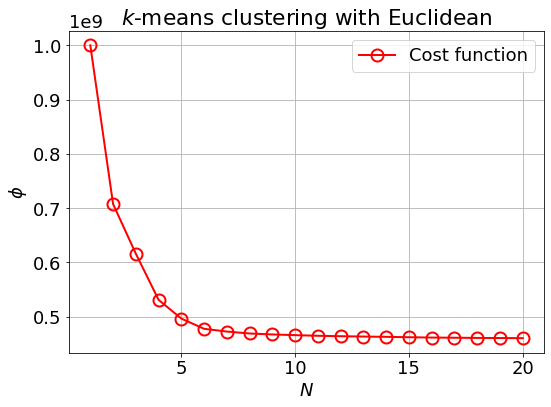

In [50]:
# Eucledian Distance plotting
fig, axs = plt.subplots(1,1,figsize=(8,6))

axs.plot(results_euclidean[:,0], results_euclidean[:,-1], 'ro-', lw=2, ms=12, mew=2, fillstyle='none',  label='Cost function')
# axs[0].plot(results[:,0], results[:,1], 'bo-', label='Intra-cluster distance')

axs.grid()
axs.set_xlabel('$N$')
axs.set_ylabel('$\phi$')
axs.legend(loc=0)
# axs[0].set_ylim(1e-8,1e0)
axs.set_title('$k$-means clustering with Euclidean')

fig.tight_layout()
plt.show()



In [51]:
# percentage change in cost function
percent_change_eucli = np.abs(results_euclidean[0,-1]-results_euclidean[9,-1])/results_euclidean[0,-1]
print("Percentage change in cost function for 10th iteration - Euclidean distance method ", round(100*percent_change_eucli,2), "%")

Percent change in cost function for 10th iteration - Euclidean distance method  53.38 %




# Manhattan distance


In [52]:
#using Manhattan
#initialized cetroids
centroids_man = centroids
# centroids_man = initialize_centroid(datazipped, kc)

#using euclidean approach
iterations = 0
#change dimesion ??
results_mann = np.zeros((max_iterations,2))
start = time.time()
while iterations < max_iterations:
  iterations += 1

  # assign each data element to closest cluster
  data_assignedto_closest_cluster =  assign_cluster_manhattan(centroids_man, datazipped)

  # compute new centroid
  new_centroids_mann = compute_new_centroids(data_assignedto_closest_cluster)

  # compute average intracluster distance 
  # intra_cluster_distance = compute_intracluster_distance(data_assignedto_closest_cluster)
  
  # compute normalized cost function
  assigned_clusters = data_assignedto_closest_cluster.map(lambda x : x[1][1]**2)
  cost_mann = assigned_clusters.sum()
  # cost_mann = assigned_clusters.sum()/n_examples

  # print the cost function
  print('iteration # %.1d : %.3f' %(iterations, cost_mann))

  # store the cost function for plotting
  results_mann[iterations-1,:] = np.array([iterations, cost_mann])
  # results_euclidean[iterations-1,:] = np.array([iterations, intra_cluster_distance, cost])

  # update centroid with the new centroid
  centroids_man = sc.parallelize(new_centroids_mann.collect())

print('Total CPU time = %.3f' %(time.time() - start))


iteration # 1 : 900941.229
iteration # 2 : 645671.320
iteration # 3 : 599748.917
iteration # 4 : 570097.802
iteration # 5 : 540872.056
iteration # 6 : 528629.481
iteration # 7 : 524763.074
iteration # 8 : 507205.077
iteration # 9 : 508086.855
iteration # 10 : 508134.825
iteration # 11 : 504334.868
iteration # 12 : 496335.350
iteration # 13 : 490703.184
iteration # 14 : 485858.246
iteration # 15 : 481501.021
iteration # 16 : 481368.090
iteration # 17 : 482498.247
iteration # 18 : 484294.007
iteration # 19 : 485173.519
iteration # 20 : 487418.133
Total CPU time = 45.425


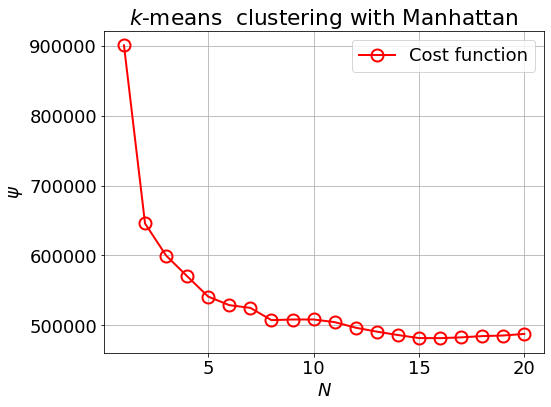

In [53]:
# Manhattan Distance plotting
fig, axs = plt.subplots(1,1,figsize=(8,6))

axs.plot(results_mann[:,0], results_mann[:,-1], 'ro-', lw=2, ms=12, mew=2, fillstyle='none',  label='Cost function')
# axs[0].plot(results[:,0], results[:,1], 'bo-', label='Intra-cluster distance')

axs.grid()
axs.set_xlabel('$N$')
axs.set_ylabel('$\psi$')
axs.legend(loc=0)
# axs[0].set_ylim(1e-8,1e0)
axs.set_title('$k$-means  clustering with Manhattan')

fig.tight_layout()
plt.show()



In [54]:
# percentage change in cost function
percent_change_mann = np.abs(results_mann[0,-1]-results_mann[9,-1])/results_mann[0,-1]
print("Percentage change in cost function for 10th iteration - Manhattan distance method ", round(100*percent_change_mann,2), "%")

Percent change in cost function for 10th iteration - Manhattan distance method  43.6 %


# Due Date: Oct. 16 at 11:59pm